## CP 218 Worksheet 6

### Bayesian Logistic Regression: MAP and Laplace Approximation

In this workshop, we will learn about approximate Bayesian inference in logistic regression. Particularly, we will focus on MAP estimation and Laplace approximation. We will use a toy dataset and do the following:

1. Implement MAP estimation and use it to compute the MAP solution
2. Compute the Laplace Approximation for the toy logistic regression problem

In [4]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

We first generate a 2D synthetic dataset with two different classes

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=42, cluster_std=4)

Xtrain, Xval, ytrain, yval = train_test_split(X, y)

(-3.0, 10.0)

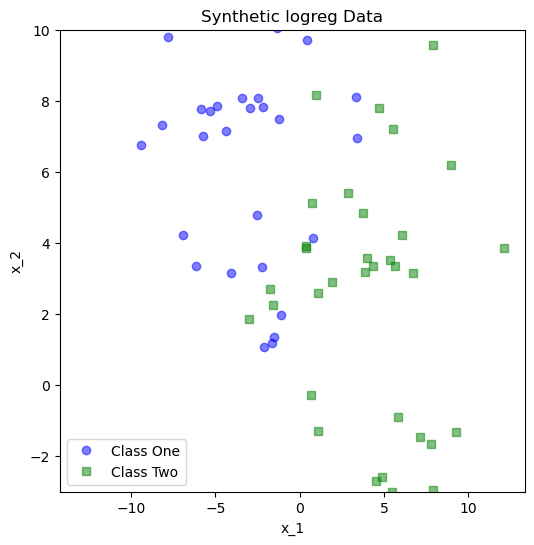

In [6]:
# plot the training data set.
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Synthetic logreg Data')

class_one = Xtrain[ytrain == 0, :]
class_two = Xtrain[ytrain == 1, :]

ax.plot(class_one[:,0], class_one[:,1], 'bo', alpha=0.5, label='Class One')
ax.plot(class_two[:,0], class_two[:,1], 'gs', alpha=0.5, label='Class Two')

ax.set_xlabel("x_1"); ax.set_ylabel("x_2")
ax.legend()
ax.set_ylim([-3, 10])

### Model Specification

The logistic regression model assumes that the outputs y are distributed as

$$p(y|w) \sim Bernoulli(\sigma(\boldsymbol{w}^\top x))$$

where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the logistic function. The probability $p(y=1) = \sigma(\boldsymbol{w}^\top x)$ is a linear function of the inputs $x$ passed through the logistic function $\sigma(z)$ in this case --- whose range is the interval $[0,1]$.

In our Bayesian logistic regression formulation, the likelihood of model is then given by,

$$p(\mathcal{D} | \boldsymbol{w})  = \prod_{n=1}^N Bernoulli(y_i | \sigma(\boldsymbol{w}^\top x_i)) = \prod_{n=1}^N \sigma(\boldsymbol{w}^\top x_i)^{y_i}(1 - \sigma(\boldsymbol{w}^\top x_i))^{(1 - y_i)}.$$

We choose a Gaussian prior just as we did in linear regression,

$$p(w) = \mathcal{N}(\boldsymbol{w} | p_m, \lambda^{-1} \boldsymbol{I}),$$

where $\lambda$ is the prior precision.

In [24]:
prior_mean = np.zeros(Xtrain.shape[1]) #p_m
lam = 0.1
prior_variance = np.eye(Xtrain.shape[1])/lam   #p_v
prior_mean
prior_variance

array([[10.,  0.],
       [ 0., 10.]])

In [8]:
Xtrain.shape

(75, 2)

#### The Laplace Approximation using MAP Estimation

#### MAP Estimation

We will now learn about the Laplace Approximation, which uses the MAP estimate to compute an approximation to the posterior distribution. Recall that MAP estimation computes the maximum of the posterior distribution (or joint likelihood distribution)

$$\mathcal{L}_{MAP} = \log p(\mathcal{D} | \boldsymbol{w}) + \log p(\boldsymbol{w}) .$$

This is achieved by minimizing the negative of the MAP objective:

$$ \boldsymbol{w}_{MAP} = argmin_{\boldsymbol{w}} (- \mathcal{L}_{MAP}) = argmin_{\boldsymbol{w}} (- \log p(\mathcal{D} | \boldsymbol{w}) - \log p(\boldsymbol{w}))$$

In the following, we provide a training loop for minimizing the MAP objective and and implementation of the log-likelihood along with its gradients.


Note that the multivariate Gaussian density is

$$ p(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}, \Sigma) = \frac{1}{(|2\pi \Sigma|)^{\frac{1}{2}}} \exp\left(-\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})\right) $$

First we will Implement ```log joint likelihood function```

In [16]:
def logJointLikelihood(X, t, w, p_m, p_v):

    """Computes the value of the negative log joint likelihood fucntion.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )

        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)

        The covariance of prior.


    Returns
    -------

    NeglogJointLikelihood : float, optional

        The value of the negative log joint likelihood fucntion.


    Reference
    ---------

    Bishop, C. M. (2006). Pattern recognition and machine learning.

    Springer. (Chapter 4.5.1)

    """

    p = 1/(1+np.exp(-X.dot(w)))
    loglikelihood =  np.sum((t*np.log(p)+(1-t)*np.log(1-p)))
    logPrior = np.log(multivariate_normal.pdf(w, p_m, p_v))

    logJointLikelihood = (loglikelihood + logPrior)
    NeglogJointLikelihood= -1*logJointLikelihood

    return NeglogJointLikelihood

In [22]:
w_init = 1e-3*np.ones(X.shape[1])
w_init

array([0.001, 0.001])

In [23]:
p = 1/(1+np.exp(-Xtrain.dot(w_init)))
np.sum((ytrain*np.log(p)+(1-ytrain)*np.log(1-p)))

-51.94972380282684

Now we will Implement ```gradient of the log joint likelihood function```

In [10]:
def logJointLikelihood_grad(X, t, w, p_m, p_v):

    """Computes the gradient of the log joint likelihood.


    Parameters
    ----------

    X : {array-like,  matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Weight Coefficient vector.


    p_m: array-like, shape (n_features, )

        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)

        The covariance of prior.


    Returns
    -------

    grad : ndarray, shape (n_features,)

        Log joint likelihood gradient.


    Reference
    ---------
    (cf. slide 14 of lecture 5 (CP 218) for prior term (consider mean p_m and lambda= inv(p_v) for prior)
    """

    p = 1/(1 + np.exp(-X.dot(w)))

    grad =  X.T.dot(p-t)+ inv(p_v).dot(w-p_m)

    return grad

Remember that ```log_likelihood``` also computes the Hessian of $- \log p(\mathcal{D}|\boldsymbol{w})$. Now we will Implement ```Hessian of the log joint likelihood```

In [11]:
def logJointLikelihood_hess(X, t, w, p_m, p_v):

    """Computes the Hessian of the log joint likelihood.


    Parameters
    ----------

    X : {array-like,  matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.

    w : ndarray, shape (n_features,)

        Weight Coefficient vector.


    p_m : array-like, shape (n_features, )

        The mean of prior.


    p_v : {array-like, sparse matrix}, shape (n_features, n_features)

        The covariance of prior.



    Returns
    -------

    hess : {array-like, sparse matrix}, shape (n_features, n_features)

        The Hessian matrix


    Reference
    ---------

    Bishop, C. M. (2006). Pattern recognition and machine learning.

    Springer. (Chapter 4.5.1)

     Hessian matrix whose elements comprise the second derivatives of negative log-joint-likelihood (or negative log posterior)
     with respect to the components of weight coefficient

    """


    p = 1/(1 + np.exp(-X.dot(w)))
    hess =  (( X.T*(p*(1-p)))).dot(X)+inv(p_v)

    return hess

Now we will Implement ```Gradient Descent ``` and ```Newton ```  method for optimization.

In [12]:
def GradientDescent(X, t, w, p_m, p_v, eta, tol, max_iter):

    """Implement gradient descent method to find optimal point for minimizing the negative

    log joint likelihood.


    Parameters
    ----------

    X : {array-like,  matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.


    w : ndarray, shape (n_features,)

        Weight Coefficient vector.


    p_m: array-like, shape (n_features, )

        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)

        The covariance of prior.


    eta: float, optional

        The learning rate


    tol : float, optional

        Tolerance for stopping criteria.


    max_iter: int, optional

        Maximum number of iterations taken for the solvers to converge.



    Returns

    -------

    w_opt: ndarray, shape (n_features,)

        The optimal coefficient vector.

    losses: ndarray, optimal

        Values of the objective function, saving for each iteration.

    """
    log_joint_likelihood = 1e5
    log_joint_likelihoods = []
    w_history=[]
    w_history.append(w)
    w_opt = 0

    for i in range(max_iter):


        grad = logJointLikelihood_grad(X, t, w, p_m, p_v)

        # update the coefficient for next step
        w_new =  w - eta*grad   #fill in
        w_history.append(w_new)

        # check convergence
        log_joint_likelihood_new = logJointLikelihood(X, t, w_new, p_m, p_v)
        if (abs(log_joint_likelihood_new - log_joint_likelihood) < tol):
            break
        else:
            log_joint_likelihoods.append(log_joint_likelihood_new)
            log_joint_likelihood, w = log_joint_likelihood_new, w_new

    w_opt = w_new
    return w_opt, np.array(log_joint_likelihoods), w_history

In [13]:
def NewtonRaphson(X, t, w, p_m, p_v, eta, tol, max_iter):


    """Implement Newton Raphson method to find optimal point

    for the minimizing the negative of log joint likelihood.


    Parameters
    ----------

    X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Training data, where n_samples is the number of samples and

        n_features is the number of features.


    t : ndarray, shape (n_samples,)

        Array of labels.


    w : ndarray, shape (n_features,)

        Coefficient vector.


    p_m: array-like, shape (n_features, )

        The mean of prior.


    p_v: {array-like, sparse matrix}, shape (n_features, n_features)

        The covariance of prior.


    eta: float, optional

        The learning rate


    tol : float, optional

        Tolerance for stopping criteria.


    max_iter: int, optional

        Maximum number of iterations taken for the solvers to converge.



    Returns

    -------

    w_opt: ndarray, shape (n_features,)

        The optimal coefficient vector.

    losses: ndarray, optional

        Values of the objective function, saving for each iteration.


    """

    # hyper-parameters setting (Note: 'loss' is set to large value to avoid first time stop)
    log_joint_likelihood = 1e5
    log_joint_likelihoods = []
    w_opt = 0
    w_history= []
    w_history.append(w)

    for i in range(max_iter):

        # find the next step length.
        grad = logJointLikelihood_grad(X, t, w, p_m, p_v)
        hess = logJointLikelihood_hess(X, t, w, p_m, p_v)

        # update the coefficient for next step
        w_new =  w-eta*(inv(hess)*grad)
        w_history.append(w_new)

        # check convergence
        log_joint_likelihood_new = logJointLikelihood(X, t, w_new, p_m, p_v)
        if (abs(log_joint_likelihood_new - log_joint_likelihood) < tol):
            break
        else:
            log_joint_likelihoods.append(log_joint_likelihood_new)
            log_joint_likelihood, w = log_joint_likelihood_new, w_new

        w_opt = w_new

    return w_opt, log_joint_likelihoods, w_history

Now we will create a ```BayesianLogistic``` class which implements Bayesian version of logistic regression.

In [14]:
class BayesianLogistic(object):


    """Bayesian Logistic Regression classifier.

    This class implements Bayesian version of logistic regression.

    Input with defined prior distribution over parameter, it updates

    the posterior distribution by the given dataset. Moreover, the posterior

    is updated by using two methods: point estimate (MAP) and Laplace approximation.

    The former is optimized by gradient descent or Newton-Raphson techiniques."""


    def __init__(self, p_m, p_v, solver='newton', eta=1e-3, tol=1e-5, max_iter=100):

        """Intialization.

        Parameters
        ----------
        p_m: array-like, shape (n_features, )

            The mean of prior, where n_features is the number of features.


        p_v: {array-like, sparse matrix}, shape (n_features, n_features)

            The covariance of prior, where n_features is the number of features.


        solver : str, {'newton', 'gd'}, optional (default='newton').

        Algorithm to use in the optimization problem.

        - 'newton' implement Newton-Raphson method, fast converge but need more computation (Hessian matrix)

        - 'gd' implement gradient descent method


        eta: float, optional (default=1e-3)

            The learning rate


        tol : float, optional (default=1e-5)

            Tolerance for stopping criteria.


        max_iter: int, optional (default=100)

            Maximum number of iterations taken for the solvers to converge.


        Attributes
        ----------

        coef_ : array, shape (1, n_features)

            Coefficient of the features in the decision function when using MAP estimate.

        log_joint_likelihood_ : ndarray, optional

            Values of the objective function (log_joint_likelihood), saving for each iteration.

        """
        self.p_m = p_m
        self.p_v = p_v
        self.solver = solver
        self.eta = eta
        self.tol = tol
        self.max_iter = max_iter


    def fit(self, X, t):


        """Fit the model according to the given training data.


        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

            Training vector, where n_samples is the number of samples and

            n_features is the number of features.


        t : array-like, shape (n_samples,)

            Target vector relative to X.



        Returns
        -------

        self : object


        """

        w_init = 1e-3*np.ones(X.shape[1])

        if (self.solver == 'gd'):
            self.coef_, self.log_joint_likelihood_, self.weight_history_ = GradientDescent(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)
        else:
            self.coef_, self.log_joint_likelihood_, self.weight_history_ = NewtonRaphson(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)

        return self


    def predict(self, X):

        """predict using the logistic model


        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]


        Returns
        -------

        T : array-like, shape = [n_samples,]

            Returns the class of the sample.

        """

        pred = []

        for p in 1/(1+np.exp(-X.dot(self.coef_))):
            if p <= 0.5:
                pred.append(0)
            else:
                pred.append(1)

        return np.array(pred)

Now we have all the functions we need. So, let's apply Bayesian logistic regression on training data (Newton-Raphson method)

In [26]:
model = BayesianLogistic(p_m=prior_mean, p_v=prior_variance, solver='gd', eta=1, max_iter=10) #try changing eta and max_iter for better convergence
model.fit(Xtrain, ytrain)

In [27]:
np.array(model.coef_)

array([ 171.15393253, -121.90893752])

In [36]:
model.log_joint_likelihood_

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Let's see how negative log_joint_likelihood changes in each iteration.

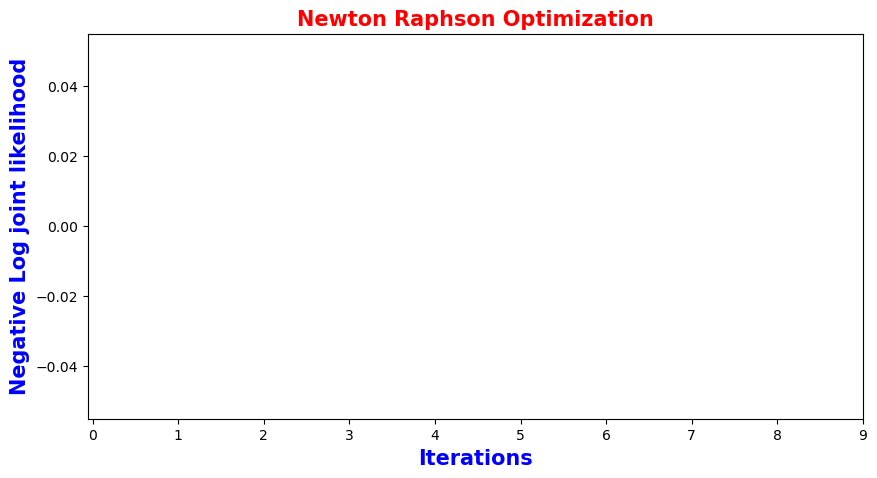

In [28]:
plt.figure(figsize=(10,5))
plt.plot(range(len(model.log_joint_likelihood_)), np.array(model.log_joint_likelihood_))
plt.xlabel("Iterations", weight="semibold", color='b', size=15)
plt.ylabel("Negative Log joint likelihood", weight="semibold", color='b', size=15)
plt.xticks(range(len(model.log_joint_likelihood_)))
plt.title("Newton Raphson Optimization", weight="semibold", color='r', size=15)
plt.show()

In [29]:
pred = model.predict(Xval)
pred

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0])

In [ ]:
###model.weight_history_
###weight_tensor = torch.tensor(model.weight_history_, requires_grad=True, dtype=torch.float)
###weight_tensor

(-3.0, 10.0)

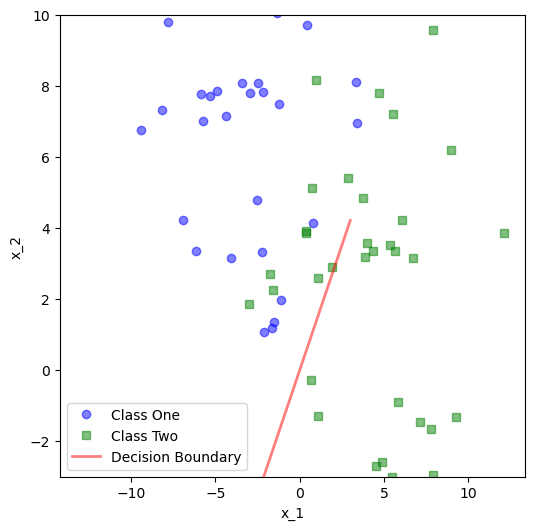

In [30]:
def plot_map_boundary(ax1, w):
    if w[1] == 0:
        boundary = 0
    else:
        boundary = - w[0] / w[1]

    x1 = np.arange(-7,4)

    ax1.plot(x1, boundary * x1, 'r', lw=2, alpha=0.5, label='Decision Boundary')
    ax1.legend()

    return ax1



# plot the training data set.
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

class_one = Xtrain[ytrain == 0, :]
class_two = Xtrain[ytrain == 1, :]

ax.plot(class_one[:,0], class_one[:,1], 'bo', alpha=0.5, label='Class One')
ax.plot(class_two[:,0], class_two[:,1], 'gs', alpha=0.5, label='Class Two')

ax.set_xlabel("x_1"); ax.set_ylabel("x_2")
plot_map_boundary(ax, np.array(model.coef_))
ax.set_ylim([-3, 10])


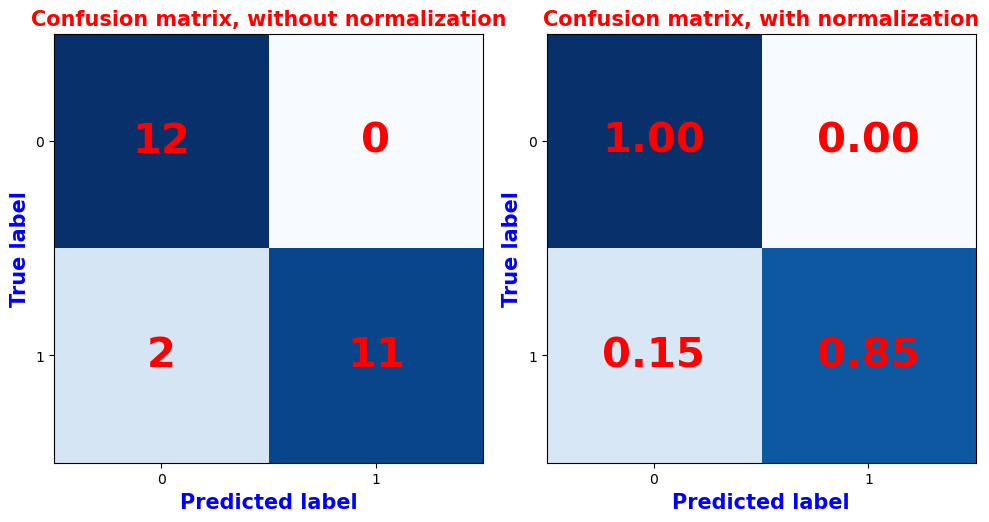

In [31]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):

    """Plot the confusion matrix.


    Parameters
    ----------
    ytrue : array-like, shape = [n_samples, ]

        The true value , where n_samples is the number of samples.

    ypred : array-like, shape = [n_samples, ]

        The predicted value

    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].imshow(cm, interpolation='nearest', cmap=cmap)
    ax[1].imshow(cm_normalize, interpolation='nearest', cmap=cmap)

    # Show all ticks
    ax[0].set_xlabel("Predicted label", weight="semibold", color='b', size=15)
    ax[0].set_ylabel("True label", weight="semibold", color='b', size=15)
    ax[0].set_title("Confusion matrix, without normalization", weight="semibold", color='r', size=15)
    ax[0].set_xticks(classes)
    ax[0].set_yticks(classes)

    ax[1].set_xlabel("Predicted label", weight="semibold", color='b', size=15)
    ax[1].set_ylabel("True label", weight="semibold", color='b', size=15)
    ax[1].set_title("Confusion matrix, with normalization", weight="semibold", color='r', size=15)
    ax[1].set_xticks(classes)
    ax[1].set_yticks(classes)

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[0].text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="r", fontsize=30, weight="semibold")
            ax[1].text(j, i, format(cm_normalize[i, j], '.2f'), ha="center", va="center", color="r", fontsize=30, weight="semibold")

    fig.tight_layout()



# Plot confusion matrix
plot_confusion_matrix(yval, pred)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, yval)

0.92

Q: What do you think about the accuracy for this dataset? Can we improve it further? How?

We can also adaptive choose learning rate. Please read Chapter 9.3 of the Stephen Boyd and Lieven Vandenberghe (2004). Convex Optimization.
Cambridge

### The Laplace Approximation

We now consider computing the Laplace Approximation to the posterior distribution for logistic regression problem. This is easy to do since we have already found MAP estimate of our model parameters, $\boldsymbol{w}_{MAP}$, using gradient descent.

Recall that the Laplace approximation is found by a second order Taylor series approximation of the log-posterior distribution at the MAP estimate:

$$ \log p(\boldsymbol{w} | \mathcal{D}) \approx \log p(\boldsymbol{w}_{MAP} | \mathcal{D}) + (\boldsymbol{w} - \boldsymbol{w}_{MAP})^\top \nabla_{\boldsymbol{w}} \log p(\boldsymbol{w}_{MAP} | \mathcal{D}) +  \frac{1}{2} (\boldsymbol{w} - \boldsymbol{w}_{MAP})^\top \nabla_{\boldsymbol{w}^2}^2 \log p(\boldsymbol{w}_{MAP} | \mathcal{D})(\boldsymbol{w} - \boldsymbol{w}_{MAP}) $$

 Remember that the covariance matrix for (approximated) posterior distribution is the inverse of Hessian of $- \log p(\mathcal{D}|\boldsymbol{w})$.

In [ ]:
class BayesianLogistic_LaplaceApproximation(BayesianLogistic):


    """Bayesian Logistic Regression classifier.

    This class inherit BayesianLogistic class. Futhermore, it is extend by

    apply Laplace approximation to find a Gaussian approximation to a posterior distribution"""

    def LaplaceApproximation(self, X, t):

        """predict using the logistic model


        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

            Training vector, where n_samples is the number of samples and

            n_features is the number of features.


        t : array-like, shape (n_samples,)

            Target vector relative to X.


        Returns
        -------

        self : object

        """

        w_init = 1e-3*np.ones(X.shape[1])
        self.pos_m, _, _ = NewtonRaphson(X, t, w_init, self.p_m, self.p_v, self.eta, self.tol, self.max_iter)#(use Newton's method)
        self.pos_v = inv(logJointLikelihood_hess(X, t, self.pos_m, self.p_m, self.p_v))  #fill in
        return self

In [ ]:
# prior distribution setting
prior_variance = np.eye(Xtrain.shape[1])/lam
prior_mean = np.zeros(Xtrain.shape[1])

# apply Bayesian logistic regression on training data
model = BayesianLogistic_LaplaceApproximation(p_m=prior_mean, p_v=prior_variance, eta=0.1, max_iter=100)
model = model.LaplaceApproximation(Xtrain, ytrain)

In [ ]:
# mean of Laplace approximation distribution
model.pos_m

In [ ]:
# variance of Laplace approximation distribution
model.pos_v

In [ ]:
import scipy as sp
# set up a 2d plot mesh
w1, w2 = np.mgrid[-1:1:.05, -1:1:.05]
grid = np.c_[w1.ravel(), w2.ravel()]

fig = plt.figure(figsize=(10,5))
# plot a bivariate normal for the prior
ax = fig.add_subplot(121)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=np.zeros(2), cov=prior_variance)
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'rx') # add prior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Prior $p(w_1, w_2|\lambda)$')

# plot a bivariate normal for the posterior
ax = fig.add_subplot(122)
p_w = sp.stats.multivariate_normal.pdf(grid, mean= model.pos_m, cov= model.pos_v)
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(model.pos_m[0], model.pos_m[1], 'rx') # add posterior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Posterior $p(w_1, w_2|X,y)$')
plt.show()